# Start

In [221]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
import multiprocessing
NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
print('Parallel processing with '+str(NumThread)+' cores')

# from util_factorial_hmm import gibbs

%load_ext autoreload
%autoreload 2

from utils_modelsel import plot_trans_matrix, fit2sources_findNumStates, compare_reconstructed_true, true2onehot_states, remove_duplicate_hmms, cluster_hmm,model_sel_ICA,fit_hmm_after_gmm,infer_timescales,reconstruct_parameters

Parallel processing with 18 cores
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate fHMM with 2 chains and different timescales

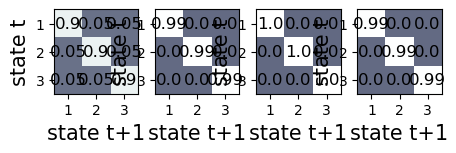

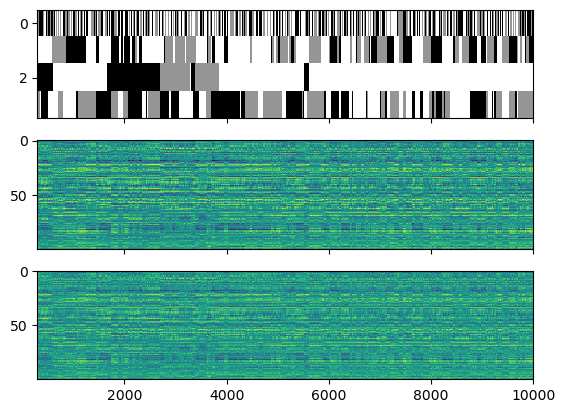

In [4]:
num_factors = 4
num_states = 3
emission_dim = 100
num_timesteps = 200000

emission_option='mixedsel' # the emissions from different factors are mixed
# emission_option='puresel'# each neuron only depends on one factor

hypers = dict(num_factors=num_factors,
              num_states=num_states,
              emission_dim=emission_dim)


initial_dist = np.ones((num_factors, num_states)) / num_states
transition_matrices=np.zeros((num_factors,num_states,num_states))
# for i in range(num_factors):
#     # transition_matrix = 0.9 * np.eye(num_states) + 0.1*np.random.rand(num_states,num_states)
#     # row_sums = transition_matrix.sum(axis=1)
#     # transition_matrix = transition_matrix /  row_sums[:, None]
#     epsi=10**(-i-1)
#     transition_matrix = (1-epsi) * np.eye(num_states)
#     mask = np.ones_like(transition_matrix, dtype=bool)
#     np.fill_diagonal(mask, False)   
#     transition_matrix[mask] = epsi/(num_states-1) 
#     # row_sums = transition_matrix.sum(axis=1)
#     # transition_matrix = transition_matrix /  row_sums[:, None]
#     transition_matrices[i]=transition_matrix

# use this below tog et 2 factors on the same timescale, see if you can recover them
for i in range(num_factors-1):
    # transition_matrix = 0.9 * np.eye(num_states) + 0.1*np.random.rand(num_states,num_states)
    # row_sums = transition_matrix.sum(axis=1)
    # transition_matrix = transition_matrix /  row_sums[:, None]
    epsi=10**(-i-1)
    transition_matrix = (1-epsi) * np.eye(num_states)
    mask = np.ones_like(transition_matrix, dtype=bool)
    np.fill_diagonal(mask, False)   
    transition_matrix[mask] = epsi/(num_states-1) 
    # row_sums = transition_matrix.sum(axis=1)
    # transition_matrix = transition_matrix /  row_sums[:, None]
    transition_matrices[i]=transition_matrix
transition_matrices[i+1]=transition_matrices[1]

if emission_option=='mixedsel':
    means = npr.randn(num_factors, num_states, emission_dim) # mixed selectivity
elif emission_option=='puresel':
    means = np.zeros((num_factors, num_states, emission_dim)) # pure selectivity
    for i in range(num_factors):
        indperm=np.random.permutation(np.arange(emission_dim))
        neuron_per_state=np.floor(emission_dim/num_states).astype(int)
        for i_st in range(num_states):
            means[i,i_st,indperm[i_st*neuron_per_state:(i_st+1)*neuron_per_state]]=npr.randn(neuron_per_state)
        means[i,num_states-1,indperm[(num_states-1)*neuron_per_state:len(indperm)]]=npr.randn(emission_dim-neuron_per_state*(num_states-1))
# variances = 0.1 * np.ones((num_factors, num_states, emission_dim))
variances=0.2*np.ones(emission_dim)

params = dict(initial_dist=initial_dist,
              transition_matrices=transition_matrices,
              means=means,
              variances=variances)

true_states = np.zeros((num_timesteps, num_factors), dtype=int)
emissions = np.zeros((num_timesteps, emission_dim))
expec_emissions = np.zeros((num_timesteps, emission_dim))

npr.seed(0)
for t in range(num_timesteps):
    for h in range(num_factors):
        if t > 0:
            true_states[t, h] = \
              npr.choice(num_states, p=transition_matrices[h, true_states[t-1, h]])
        
    # mean = np.zeros(emission_dim)
    # for h in range(num_factors):      
    #     mean += means[h, states[t,h], :]
    expec_emissions[t] = np.sum(means[np.arange(num_factors), true_states[t]], axis=0)
    emissions[t] = expec_emissions[t] + np.sqrt(variances) * npr.randn(emission_dim)

data={'emissions':emissions,'true_states':true_states,'expec_emissions':expec_emissions,'params':params}
x=np.save('data1.npy',data)



plt.figure(figsize=(5, 12))
for i in range(num_factors):
    ax = plt.subplot(1, num_factors, i+1)
    plot_trans_matrix(transition_matrices[i])

fig, axs = plt.subplots(3, 1, sharex=True)
axs[0].imshow(true_states.T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(expec_emissions.T, aspect="auto", interpolation="none")
axs[2].imshow(emissions.T, aspect="auto", interpolation="none")

# axs[3].imshow(mean, aspect="auto", interpolation="none")

plt.xlim(300, 10000)

flat_one_hot_states=true2onehot_states(true_states)


# Model selection

1. Perform cross-validated ICA to select for the number of ICA sources $L$. Given the data $Y_{i,t}$ for neuron $i$ and time $t$, we perform ICA on the whitened data to obtain the $L$ sources $s_{l,t}$ and the mixing matrix $H_{i,l}$ with
$$
Y_{i,t}=\sum_{l=1}^{L}H_{i,l}S_{l,t}+Y_{mean} \ .
$$

2. On each of the sources $l=1,\ldots,L$, run model selection with a gaussian mixture model (GMM) to find the optimal number of mixtures $n_l$ that best describe that source. 

3. For each source $l$, fit an HMM with $m=1,\ldots,M_l$ states to each source $S_{l,t}$ and store posteriors and emissions
          $$
          S_{l,t}=\sum_{m=1}^{M_l}e_m^{(l)}p^{(l)}(m,t)
          $$
          where $\{e_m^{(l)},p^{(l)}(m,t)\}$ are the emissions and posterior probabilities for HMM state $m$ for source $l$.

4. Concatenate all posteriors from all HMM of all sources for a total of $S=\sum_{l=1}^L M_l$, and estimate their $S x S$ correlation matrix. Find groups of highly correlated posteriors (abs(corr)$>0.95$) representing identical copies of the same HMM state that was detected in more than one ICA source. For each group of highly correlated posteriors, keep only one copy and drop the rest, thus decreasing the number of total posteriors from S to $\hat S$.

5. Consider the $\hat S \times \hat S$ correlation matrix between the surviving posteriors, and now perform hierarchical clustering on it, to find $c=1,\ldots,C$ chains of most anticorrelated posteriors, each group with $N_c$ states. E.g., groups of posteriors with anticorrelation of $-0.5$ correspond to a Markov chain with 3 states. Normalize the posteriors within each chain such that $\sum_{n=1}^{N_c}p^{(c)}(n,t)=1$ for all $t$ and all chains $c$, so that the original data reads
$$
Y_{i,t}=\sum_{l=1}^{L}H_{i,l}S_{l,t}+Y_{mean} =\sum_{c=1}^C H_{i,c} \sum_{n=1}^{N_c}e_n^{(c)}p^{(c)}(n,t)
$$

6. Initialization of fHMM parameters. The procedure above defines an fHMM with **emissions** $E_i(n,c)$ for state $n$ in chain $c$ given by
$$
E_i(n,c)=H_{i,c}e_n^{(c)}+Y_{mean,i},
$$
**transition probabilities** $A_{nm}^{(c)}$ and initial distribution $\pi_n^{(c)}$ for the chain c obtained from the posteriors as:
$$
A_{nm} \ ,\qquad \pi_n^{(c)}=p^{(c)}(n,t=0) \ .
$$




# Step 1: select number of ICA sources

/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/ssm_

Optimal number of components based on the elbow method: 8


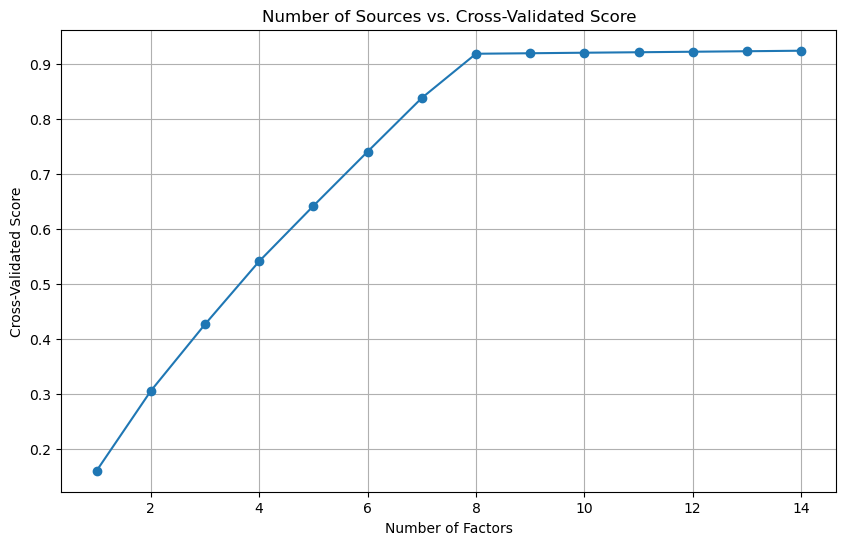

<Figure size 640x480 with 0 Axes>

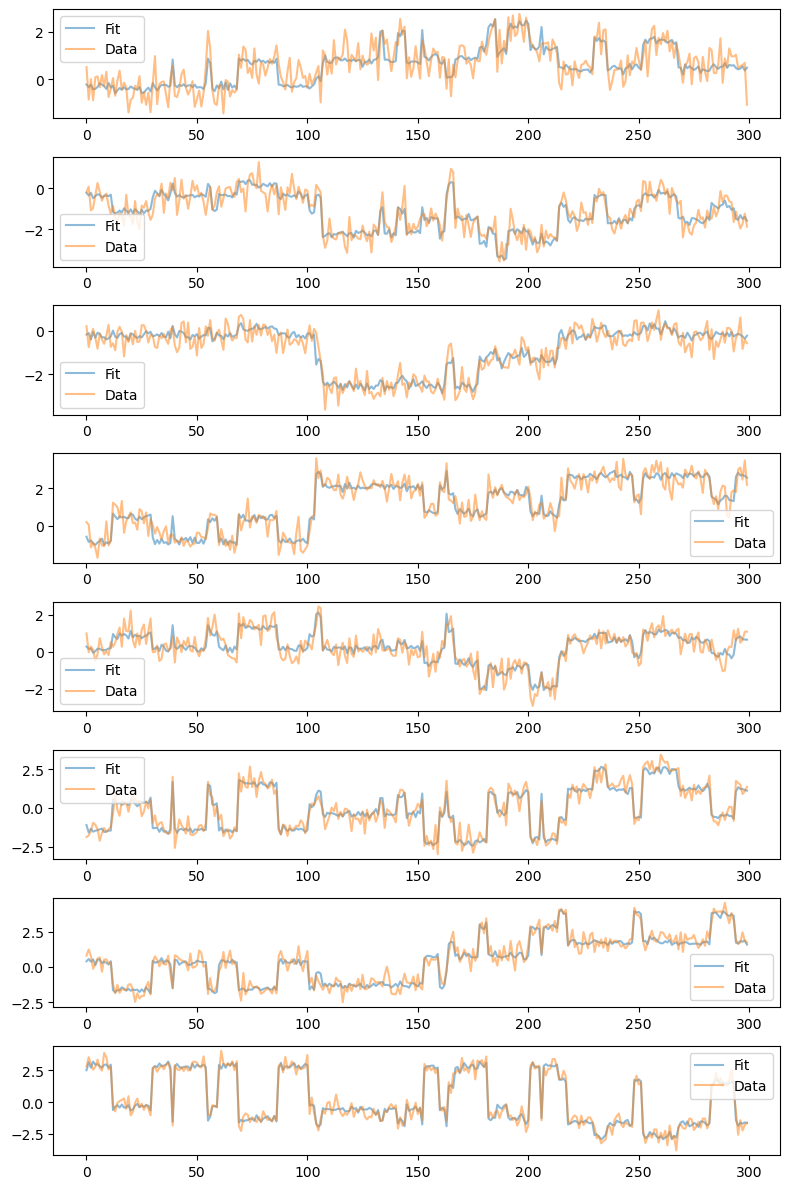

<Figure size 640x480 with 0 Axes>

In [5]:
emissions_data=emissions
MAX_runs=50
ica,optimal_n_components=model_sel_ICA(emissions_data,MAX_runs=50)
factors=ica.transform(emissions_data)
num_factors_FA=factors.shape[1]


## Step 1.1: Estimate timescale for each factor, cluster timescales

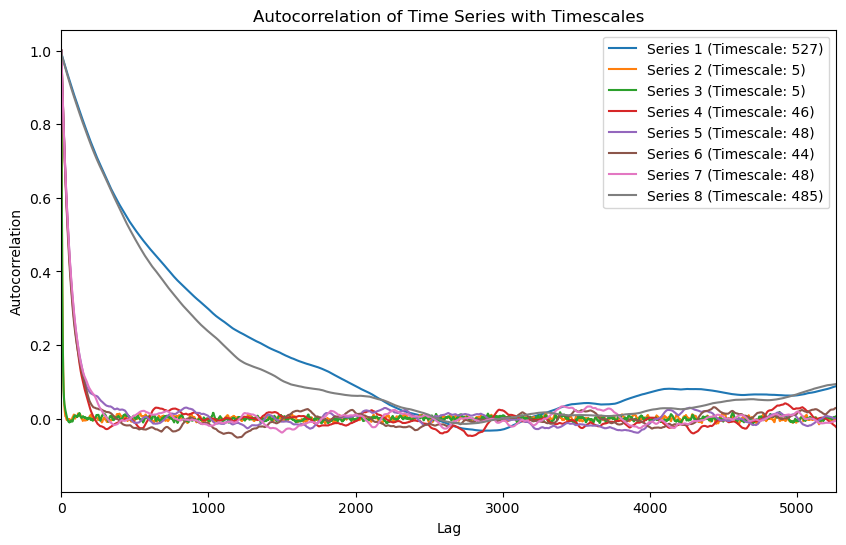

Timescales: [527, 5, 5, 46, 48, 44, 48, 485]


/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/

Optimal number of clusters: 3
Labels: [2 0 0 1 1 1 1 2]
Timescales: [527, 5, 5, 46, 48, 44, 48, 485]


/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/mazzu/opt/anaconda3/envs/ssm_dynamax/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Figure size 640x480 with 0 Axes>

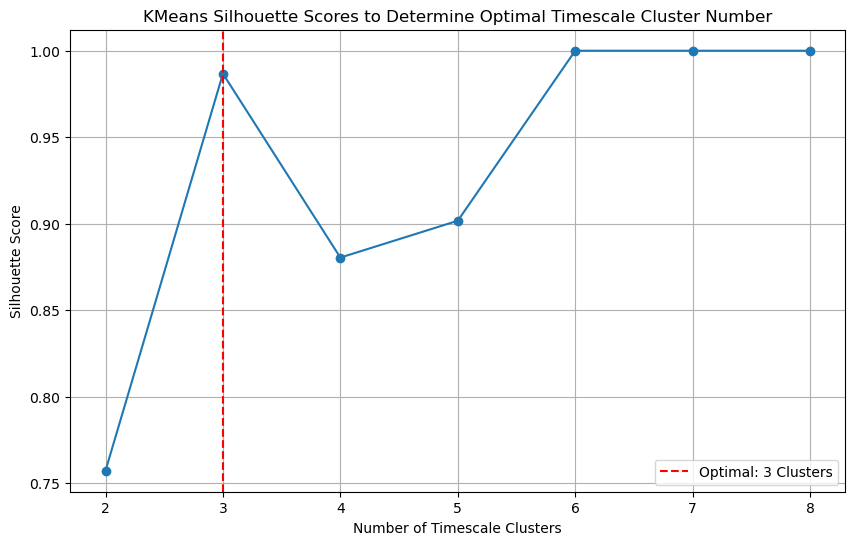

<Figure size 640x480 with 0 Axes>

In [6]:
timescales,labels,optimal_n_timescales=infer_timescales(factors)

# Step 2: Find best number of GMM for each ICA source

In [126]:
from joblib import Parallel, delayed
from utils_modelsel import evaluate_gmm_k_fold
from sklearn.model_selection import KFold
from dynamax.hidden_markov_model import GaussianHMM
from jax import random as jr



def fit2sources_findNumStates(factors,option='HMM'):
        # Assuming `factors` is your T x N numpy array
        N = factors.shape[1]
        # Parallelize across features
        results = Parallel(n_jobs=-1)(delayed(find_best_k)(factors[:, n].reshape(-1, 1),option) for n in range(N))
        n_states=[results[i]['best_k'] for i in range(len(results))]

        # Plotting
        _,N=factors.shape
        fig, axes = plt.subplots(1, N, figsize=(N*5, 4), sharey=True)
        fig.suptitle('Best K using K-Fold Cross-Validation')
        for n, result in enumerate(results):
                axes[n].plot(range(1, len(result['log_likelihoods'])+1), result['log_likelihoods'], marker='o', linestyle='-')
                axes[n].axvline(x=result['best_k'], color='r', linestyle='--', label=f'Best K = {result["best_k"]}')
                axes[n].set_title(f'Feature {n+1}')
                axes[n].set_xlabel('Number of '+option+' States (K)')
                axes[n].set_ylabel('Log-likelihood')
                axes[n].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig('ModelSel_'+option+'BestK.png')
        plt.show()  

        return results,n_states


def find_best_k(feature_data, option):
    """
    Finds the best K using the elbow method on K-fold cross-validation log-likelihood.

    Parameters:
    - feature_data: Data for a single feature.
    - max_k: Maximum number of components to consider.
    - n_splits: Number of splits for K-fold cross-validation.

    Returns:
    - A dictionary with 'best_k' and 'log_likelihoods'.
    """
    MAX,count,old_optimal_n_components=10,0,0
    average_variances = []
    for n_components in range(1,MAX):
          if option=='GMM':
            n_splits=5
            average_variance=evaluate_gmm_k_fold(feature_data, n_components, n_splits)
          elif option=='HMM':
            n_splits=3
            average_variance=evaluate_hmm_k_fold(feature_data, n_components, n_splits)
          average_variances.append(average_variance)
          # Find the elbow point
          if n_components>5:
                    diffs = np.diff(average_variances)
                    threshold = 0.1 * np.abs(diffs[0])
                    elbows = np.where(np.abs(diffs) < threshold)[0]
                    new_optimal_n_components = elbows[0] + 1 if len(elbows) > 0 else MAX
                    # new_optimal_n_components = find_elbow_point(average_variances)
                    if new_optimal_n_components==old_optimal_n_components:
                              count+=1
                    else: count=0
                    if count>2:
                              break
                    old_optimal_n_components=new_optimal_n_components
    optimal_n_components=new_optimal_n_components
    # max_n_components=n_components
    print(optimal_n_components)
    print(average_variances)
    out_return={'best_k': optimal_n_components, 'log_likelihoods': average_variances}
    return out_return


def evaluate_hmm_k_fold(synthetic_data, K, n_splits=3):
    """
    Evaluates HMM for a single feature using K-fold cross-validation.

    Parameters:
    - synthetic_data: Data for the feature (should be a 2D array).
    - K: Number of components for GMM.
    - n_splits: Number of splits for K-fold cross-validation.

    Returns:
    - Average log-likelihood across all folds.
    """

    kf = KFold(n_splits=n_splits)
    N_iters = 500 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
    TOL=10**-4 # tolerance parameter (see N_iters)
    nRunEM=1 # # of times we run EM for each choice of number of states
    # initialized training and test loglik for model selection, and BIC
    ll_training = np.zeros((n_splits,nRunEM))
    ll_heldout = np.zeros((n_splits,nRunEM))
    results=[]
    for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
        data_in={'training_data':synthetic_data[train_index],'test_data':synthetic_data[test_index],
                'N_iters':N_iters,'TOL':TOL}
        for iRun in range(nRunEM):
            key = jr.PRNGKey(iRun)
            results.append(xval_func(data_in, K,key))
        # results = Parallel(n_jobs=NumThread)(
        #     delayed(xval_func)(data_in, num_states0)
        #     for iRun,num_states0 in zip(RunN,stN))
        # unpack
        for i in range(nRunEM):
            ll_training[iK,i]=results[i]['ll_training']
            ll_heldout[iK,i]=results[i]['ll_heldout']
    ll_heldout_mean=np.mean(ll_heldout.flatten())

    return ll_heldout_mean



def xval_func(data_in,num_states0,key):
    
    training_data=data_in['training_data']
    test_data=data_in['test_data']
    N_iters=data_in['N_iters']
    TOL=data_in['TOL']
    
    obs_dim = len(training_data[0])             # number of observed dimensions: outcome
    nTrain=len(training_data)
    nTest=len(test_data)
    
    out={}
    # fit HMM with ssm
    mle_hmm = HMM(num_states0, obs_dim, 
          observations="gaussian", transitions="standard")
    #fit on training data
    hmm_lls = mle_hmm.fit(training_data, method="em", num_iters=N_iters, tolerance=TOL)                
    # Compute log-likelihood for each dataset
    out['ll_training'] = mle_hmm.log_likelihood(training_data)/nTrain
    out['ll_heldout'] = mle_hmm.log_likelihood(test_data)/nTest
    # ## fit hmm with dynamax
    # run_glmhmm=GaussianHMM(num_states0, obs_dim)
    # em_params, em_param_props = run_glmhmm.initialize(key)
    # # em_params, em_param_props = run_glmhmm.initialize(key, method="kmeans", emissions=training_data)
    # em_params, hmm_lls = run_glmhmm.fit_em(em_params, 
    #                               em_param_props,
    #                               training_data, num_iters=N_iters, tolerance=TOL)
    # out['ll_training'] = hmm_lls[-1]/nTrain
    # out['ll_heldout'] = run_glmhmm.marginal_log_prob(em_params, test_data)/nTest    
    return out


takes about 30 min

LP: 87933.3:  44%|████▍     | 220/500 [00:40<00:45,  6.10it/s]]

3
[-1.4280251042121417, 0.09615169358240312, 1.0825229567405323, 1.101486679528394, 1.1207938908140094, 1.1013929378330514, 1.1221320084760888, 1.1245190871847617, 1.1245353581426383]


LP: 101510.4:  77%|███████▋  | 384/500 [01:01<00:17,  6.49it/s]

3
[-1.4166346743672584, 0.09972550849195731, 0.9788045031766338, 0.9787947924199948, 0.9921864402700346, 0.992159634105456, 0.9921298281626347, 1.0065146237875446, 1.008861916348882]


LP: 101524.8:  86%|████████▌ | 431/500 [01:09<00:10,  6.62it/s]

2
[-1.419701697853381, 0.023339081629216944, 0.04802504242929297, 0.9194441929924969, 0.9174670650961173, 0.9194199369526651, 0.9505837728673422, 0.9451203859822339, 0.9450607935515217]


LP: 130449.7:  63%|██████▎   | 314/500 [00:55<00:31,  5.99it/s]

3
[-1.4238724068099484, 0.13131881614920946, 1.0521078814319669, 1.0731195205943627, 1.0786646348385431, 1.0730382546202535, 1.1221382230321448, 1.1011902423336646, 1.0786236365958062]


LP: 121258.9:  60%|█████▉    | 298/500 [00:50<00:33,  6.05it/s]

5
[-1.3844265166192946, -0.18663623139702556, 0.9634181322432168, -0.17447919585160263, 0.9759544316996975, 0.9790927492382825, 0.9789261425395895, 0.9887317815007209, 0.9934696758844352]


LP: 101345.9:  22%|██▏       | 112/500 [00:16<00:55,  6.96it/s]

3
[-1.4664053368204542, 0.2970569837991161, 0.8721762083755102, 0.8839427869295148, 0.8845742623263012, 0.882692316719572, 0.8845910794448092, 0.9135218553234162, 0.8964160769587736]


LP: 101360.5:  42%|████▏     | 209/500 [00:35<00:49,  5.87it/s]

3
[-1.413758532586946, -0.32328556284823734, 0.6599363603860446, 0.6599277246924818, 0.6599180655931842, 0.6604565575534579, 0.6604572237421019, 0.6604682750663872, 0.6620837881583951]


LP: 101536.4: 100%|██████████| 500/500 [01:24<00:00,  5.95it/s]


2
[-1.4241652754516727, 0.31449681755542425, 0.31449681744551494, 0.7580600057874912, 0.7583664841171971, 0.7578992055341608, 0.758056404120025, 0.7611072578447874, 0.7582820984808126]


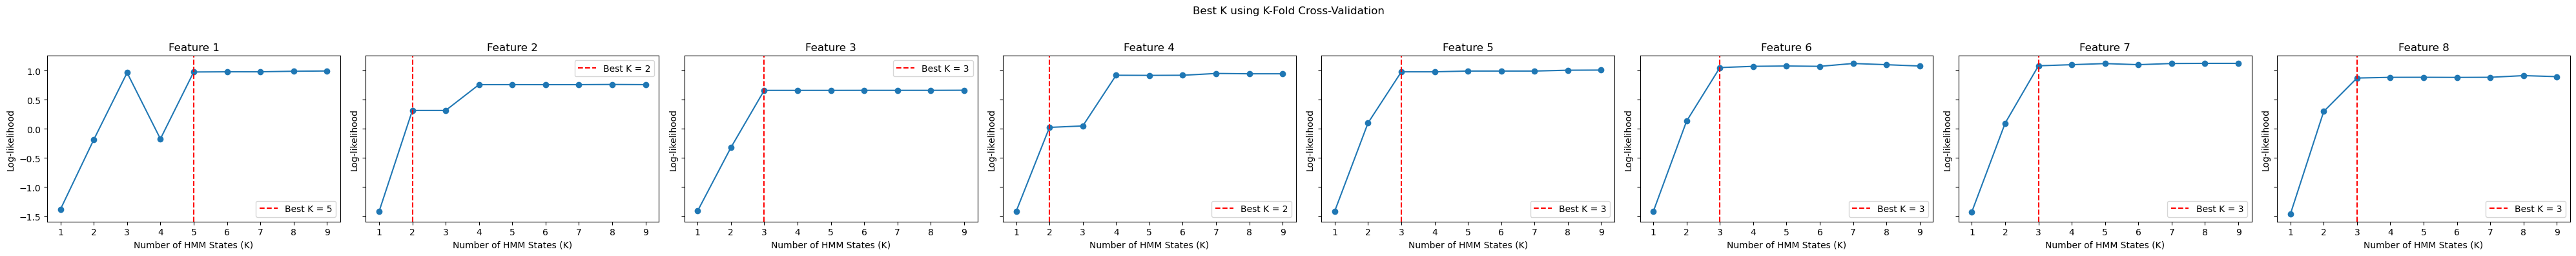

In [127]:
option='HMM' # this takes at least 30min
option='GMM' # this takes 10s, it works great with simulated data, not as much with real data.
results,n_states_best = fit2sources_findNumStates(factors,option)



# Step 3: Fit an HMM to each source, with given number of states from step 2.

Converged to LP: 54863.1:   4%|▍         | 41/1000 [00:06<02:43,  5.88it/s]


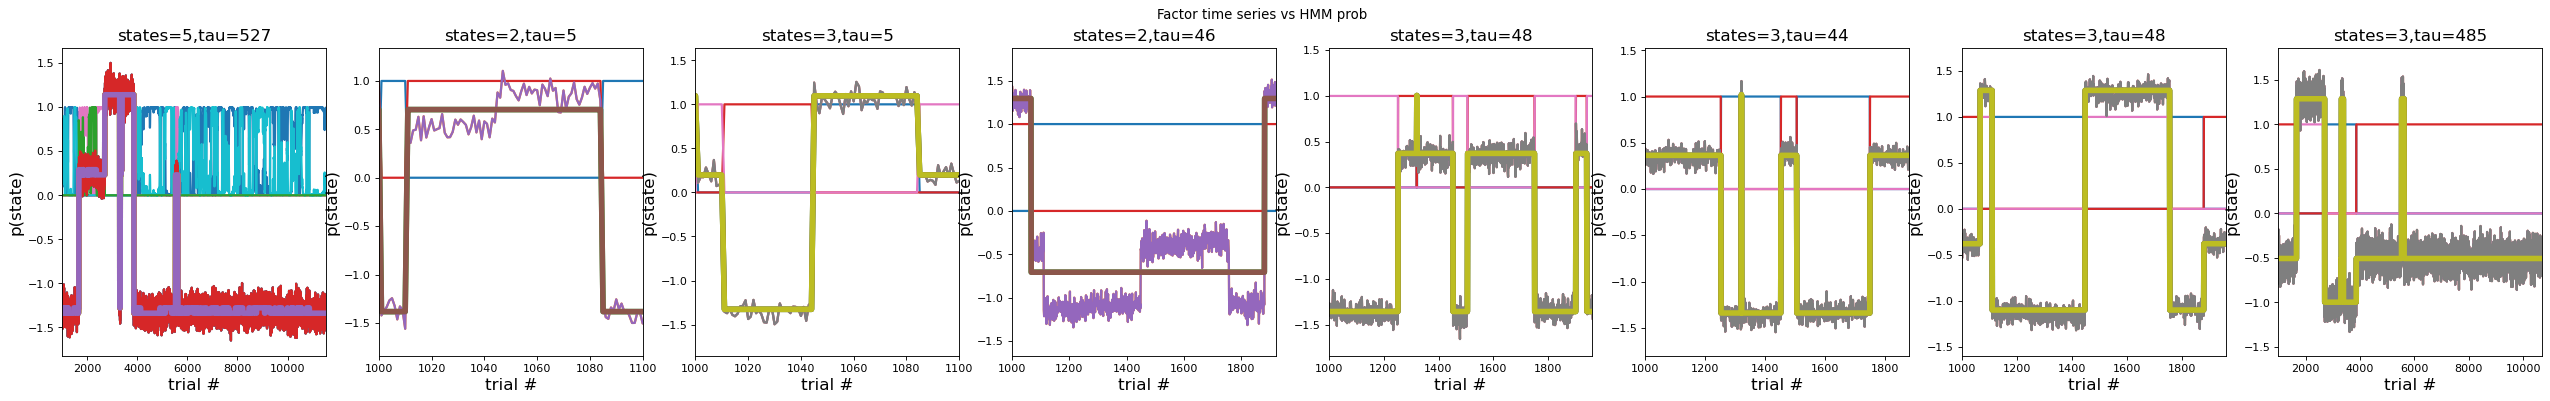

In [146]:

hmm_fits=fit_hmm_after_gmm(factors,n_states_best,timescales)


## Step 4.1: Find groups of copies of HMM posteriors (highly correlated) and remove them 

{1, 21}
{9, 5, 6}
{19, 10, 11}
{17, 12}
{13, 15}
{16, 14}


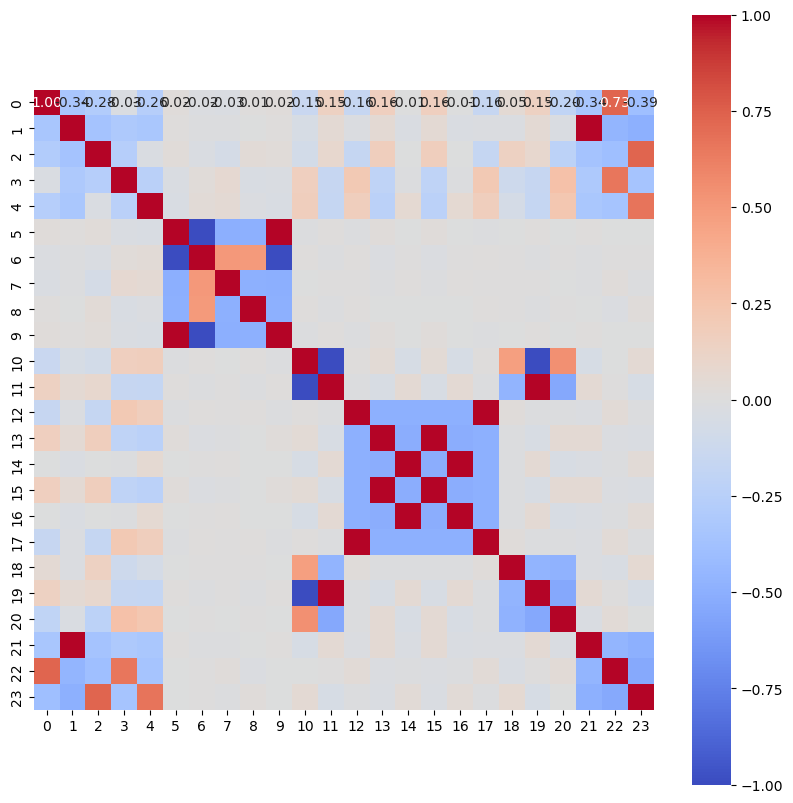

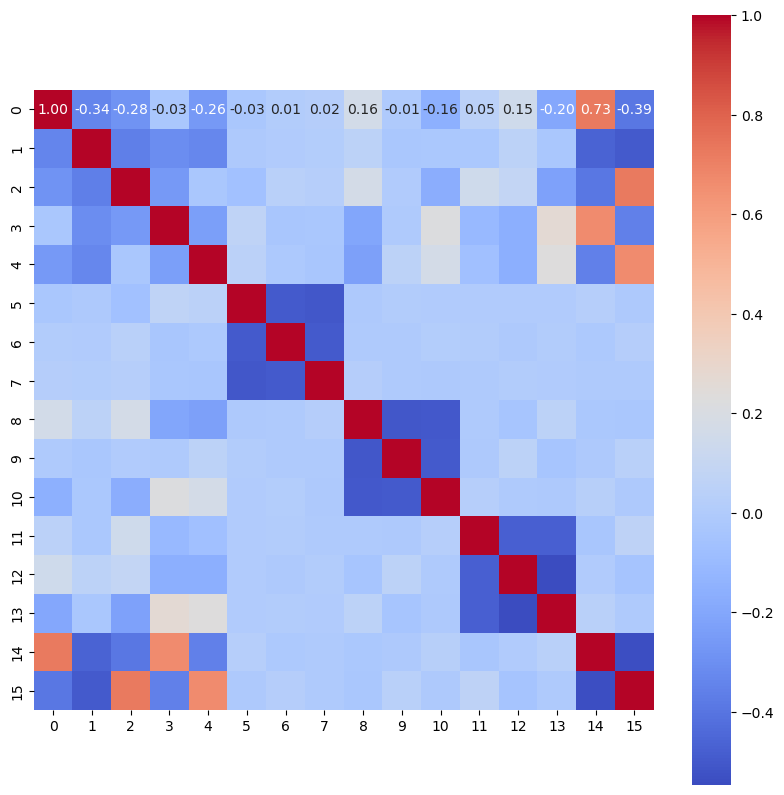

In [223]:
data_factors_to_keep,new_corr_matrix,data_factors=remove_duplicate_hmms(hmm_fits,labels)

## Step 5: Perform hierarchical clustering to find groups of anticorrelated posteriors 

/Users/mazzu/Library/CloudStorage/Dropbox/neuro/PROJECTS/factorial_hmm/utils_modelsel.py:439: RuntimeWarning: Mean of empty slice
  average = np.nanmean(matrix_copy)


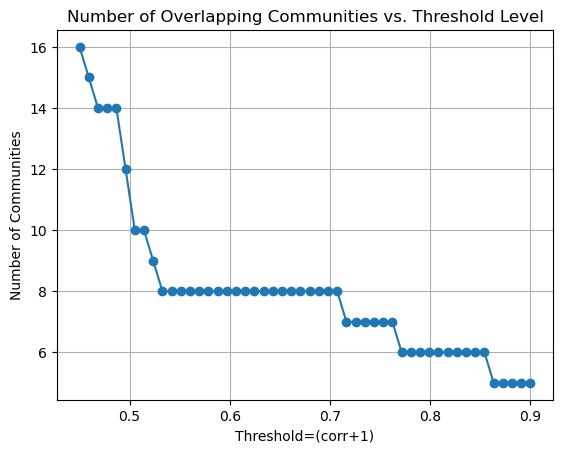

/Users/mazzu/Library/CloudStorage/Dropbox/neuro/PROJECTS/factorial_hmm/utils_modelsel.py:807: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{float(tick.get_text()) - 1:.2f}' for tick in plt.gca().get_yticklabels()])


<Figure size 640x480 with 0 Axes>

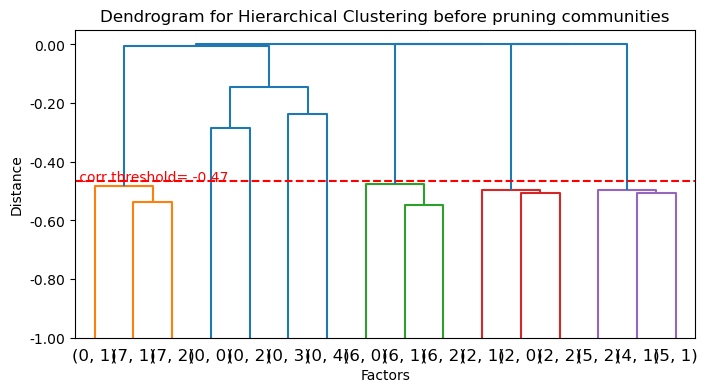

<Figure size 640x480 with 0 Axes>

In [224]:



correlation_matrix = new_corr_matrix
id_communities,mean_corr_communities,data_factors_to_keep_filtered=cluster_hmm(correlation_matrix,data_factors_to_keep)

## Step 6: Reconstruct HMM posteriors and parameters for fHMM initialization.

In [225]:


means_rec,posteriors_rec,transitions_rec,init_rec=reconstruct_parameters(id_communities,data_factors_to_keep_filtered,ica)
sigmas=emissions_data.std(axis=0)

[array([1.76741222e-175, 8.54470721e-169, 1.27894441e-186, ...,
       1.32525292e-151, 5.43031966e-163, 1.14696316e-138]), array([1.        , 1.        , 1.        , ..., 1.        , 0.999999  ,
       0.99999934]), array([3.39265889e-76, 8.21667427e-74, 2.13909269e-65, ...,
       3.04675441e-67, 1.34744132e-98, 2.09948522e-81])]
[array([5.64484453e-027, 1.96834953e-019, 2.20961319e-022, ...,
       2.67821127e-219, 1.94723185e-203, 1.08780114e-221]), array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
       2.61662026e-109, 2.81556824e-098, 3.08647836e-110]), array([2.07350950e-121, 5.70505385e-120, 3.00720050e-113, ...,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000])]
[array([2.64054600e-026, 5.06868549e-030, 1.15241686e-019, ...,
       2.33771372e-174, 5.81111956e-203, 1.00000000e+000]), array([9.30352739e-096, 2.74940729e-071, 7.87280467e-089, ...,
       1.00000000e+000, 1.00000000e+000, 1.10529517e-165]), array([1.00000000e+00, 1.00000000e+00, 1.00000000

## Compare reconstructed parameters with model parameters

ICA Factor 0 is matched with true state 7 with correlation 1.0
ICA Factor 2 is matched with true state 8 with correlation 1.0
ICA Factor 4 is matched with true state 9 with correlation 1.0
ICA Factor 7 is matched with true state 2 with correlation 1.0
ICA Factor 8 is matched with true state 0 with correlation 1.0
ICA Factor 5 is matched with true state 11 with correlation 0.9999999999999999
ICA Factor 6 is matched with true state 1 with correlation 0.9999999999999978
ICA Factor 3 is matched with true state 10 with correlation 0.999999999999993
ICA Factor 9 is matched with true state 3 with correlation 0.9999999955829725
ICA Factor 10 is matched with true state 5 with correlation 0.9999996647279549
ICA Factor 11 is matched with true state 4 with correlation 0.9999996604670928
ICA Factor 1 is matched with true state 6 with correlation 0.9999898701170433
corr_mus is [0.5505260773417066, 0.7158394282690597, 0.07095949247914748, 0.6762250756440016, 0.3131835866223935, 0.7027099192604016, 0.

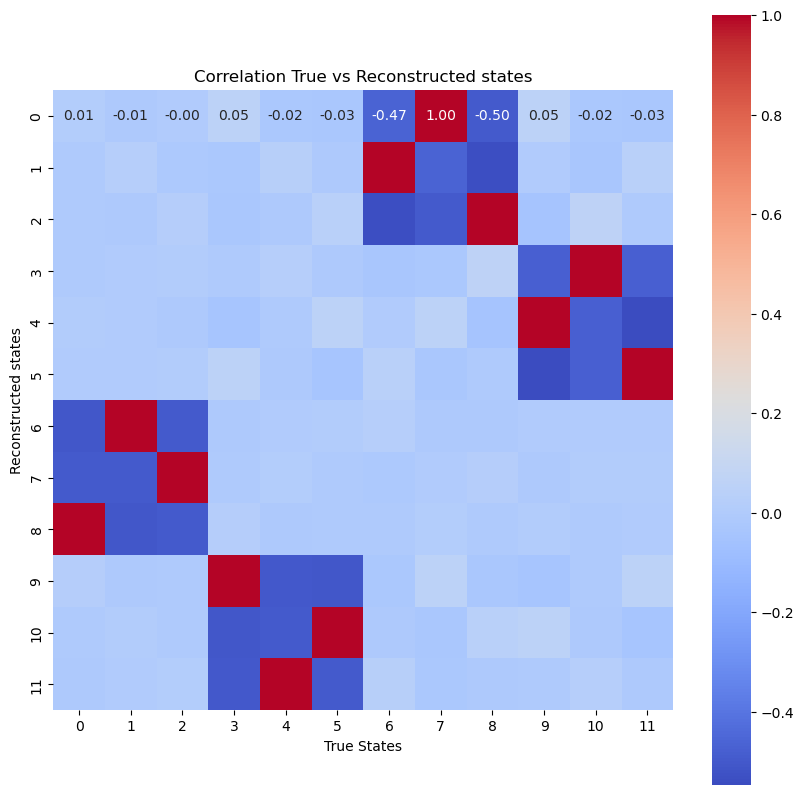

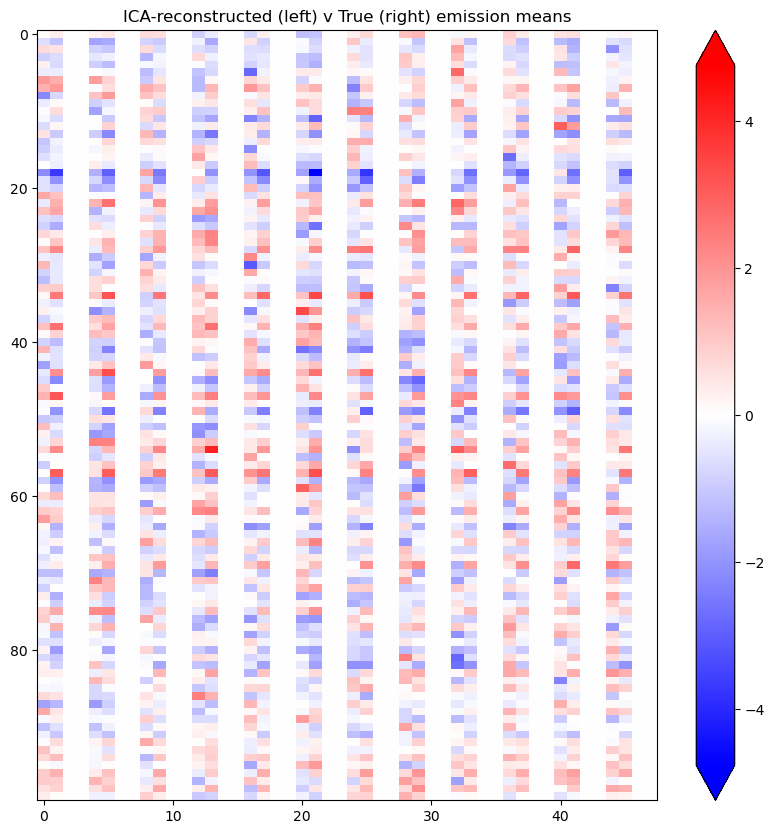

In [226]:
compare_reconstructed_true(means_rec,posteriors_rec,data)